# Here I try to implement quaternion transforms to the pipeline

In [14]:
import slampy
import cv2
import numpy as np
from utils import *
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import rosbag
import numpy as np
from IPython.display import clear_output, display
from tqdm.notebook import tqdm
from scipy.spatial.transform import Rotation as R
%matplotlib inline

In [15]:
setting_file ='settings.yaml'

In [16]:
from numpy import sin, cos, pi
# Shift vectors from camera to robot center
shift_vecs = [
    np.array([-37.477 / 100, 7.778 / 100, 0]),
    np.array([-37.477 / 100, -7.778 / 100, 0]),
    np.array([-21. / 100, 0, 0]),
    np.array([-37.477 / 100, 7.778 / 100, 0]),
    np.array([-37.477 / 100, -7.778 / 100, 0]),
    np.array([-21. / 100, 0, 0])
]
# Rotation quaternions from camera to lidar frame
rot_quats = [
    R.from_quat([0, 0, sin(-pi/8), cos(-pi/8)]),
    R.from_quat([0, 0, sin(pi/8), cos(pi/8)]),
    R.from_quat([0, 0, sin(pi/4), cos(pi/4)]),
    R.from_quat([0, 0, sin(3*pi/8), cos(3*pi/8)]),
    R.from_quat([0, 0, sin(-3*pi/8), cos(-3*pi/8)]),
    R.from_quat([0, 0, sin(-pi/4), cos(-pi/4)])
]

In [17]:
# Calculate position and orientation of robot given the pos and orientation of single camera
def calc_robot_position(sv, rq, cam_num, pos, quat):
    robot_shift_vec = quat.apply(sv[cam_num])
    new_quat = quat * rq[cam_num]
    robot_pos = pos + robot_shift_vec
    return robot_pos, new_quat

# Calculate position and orientation of any camera given the pos and orientation of robot
def calc_cam_position(sv, rq, cam_num, pos, quat):
    new_quat = rq[cam_num].inv() * quat
    cam_shift_vec = new_quat.apply(sv[cam_num])
    cam_pos = pos - cam_shift_vec
    # cam_pos = pos
    return cam_pos, new_quat

In [18]:
def load_image_from_msg(msg):
    im = np.frombuffer(msg.data, dtype=np.uint8).reshape(msg.height, msg.width, -1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

In [19]:
def calc_trajectory(app:slampy.System, bag:rosbag.Bag, topics, cam_num=None):
    positions = []
    quaternions = []
    raw_outputs = []
    timestamps = []
    
    disp_current_frame_num = display('Frame num', display_id=True)
    disp_current_state = display('Current state',display_id=True)
    disp_conseq_ok = display('Consecutive ok frames',display_id=True)
    disp_conseq__not_ok = display('Consecutive not ok frames',display_id=True)
    disp_overall_ok = display('Overall ok frames',display_id=True)
    disp_overall_not_ok = display('Overall not ok frames',display_id=True)
    disp_current_pos = display('Current pos', display_id=True)
    
    current_frame_num = 0
    conseq_ok = 0
    conseq_not_ok = 1
    overall_ok = 0
    overall_not_ok = 0
    
    
    for topic, msg, t in bag.read_messages(topics=topics):

        current_frame_num += 1

        im = load_image_from_msg(msg)
        state = app.process_image_mono(im,t.to_sec() + timestamp_shift)

        if state == slampy.State.OK:
            conseq_not_ok = 0
            conseq_ok += 1
            overall_ok += 1

            new_pose = app.get_pose_to_target()
            # FIXED THIS GODDAMN XZY
            # raw_p = new_pose[0:3, 3].flatten()[[0,2,1]]
            raw_p = new_pose[0:3, 3].flatten()[[2,0,1]]
            raw_r = R.from_quat(R.from_matrix(new_pose[:3, :3]).as_quat()[[2,0,1,3]])
            if cam_num == None:
                new_p = raw_p
                new_r = raw_r
            else:
                new_p, new_r = calc_robot_position(shift_vecs, rot_quats, cam_num, raw_p, raw_r)
            positions.append(new_p)
            quaternions.append(new_r.as_quat())
            raw_outputs.append(new_pose)
            timestamps.append(t.to_nsec())
            disp_current_pos.update(new_p)
        else:
            conseq_not_ok += 1
            conseq_ok = 0
            overall_not_ok += 1

        disp_current_frame_num.update("Frame num: " + str(current_frame_num))
        disp_current_state.update(state)
        disp_conseq_ok.update("Consecutive ok: " + str(conseq_ok))
        disp_conseq__not_ok.update("Consecutive not ok: " + str(conseq_not_ok))
        disp_overall_ok.update("Overall ok: " + str(overall_ok))
        disp_overall_not_ok.update("Overall not ok: " + str(overall_not_ok))
    print("Overall ok: " + str(overall_ok))
    print("Overall not ok: " + str(overall_not_ok))
    return positions, quaternions, raw_outputs, timestamps

In [20]:
app = slampy.System(setting_file,slampy.Sensor.MONOCULAR)

the input sensor select is MONOCULAR


In [21]:
bag = rosbag.Bag("/hermesbot/datasets/with_lidar_20220609/cameras.bag")

In [34]:
app.reset()

In [38]:
import pickle

In [41]:
bag = rosbag.Bag("/hermesbot/new_20220609_thr95.bag")
app.reset()
p, q, r, t = calc_trajectory(app, bag, topics='/camera/image_raw', cam_num=None)
p_df = pd.DataFrame(np.array(p), columns=["x", "y", "z"])
r_df = pd.DataFrame(np.array(q), columns=["qx", "qy", "qz", "qw"])
t_df = pd.DataFrame(np.array(t), columns=["t"])
df = pd.concat((t_df, p_df, r_df), axis=1)
fname = 'results/2022-06-09_orbslam2_concat_bag_nomap'
df.to_csv(fname + '.csv', index=False)
with open(fname + 'pickle', 'wb') as f:
    pickle.dump(r, f)

'Frame num: 3814'

<State.LOST: 2>

'Consecutive ok: 0'

'Consecutive not ok: 1'

'Overall ok: 3177'

'Overall not ok: 637'

array([ 0.40842587,  0.8311356 , -0.02110698], dtype=float32)

Overall ok: 3177
Overall not ok: 637


In [42]:
bag = rosbag.Bag("/hermesbot/datasets/with_lidar_20220610/2022-06-10-12-48-50.bag")

In [40]:
for cn in range(6):
    app.reset()
    p, q, r, t = calc_trajectory(app, bag, topics='/cam' + str(cn) + '/image_raw', cam_num=cn)
    p_df = pd.DataFrame(np.array(p), columns=["x", "y", "z"])
    r_df = pd.DataFrame(np.array(q), columns=["qx", "qy", "qz", "qw"])
    t_df = pd.DataFrame(np.array(t), columns=["t"])
    df = pd.concat((t_df, p_df, r_df), axis=1)
    fname = 'results/2022-06-09_orbslam2_cam' + str(cn) + '_nomap'
    df.to_csv(fname + '.csv', index=False)
    with open(fname + 'pickle', 'wb') as f:
        pickle.dump(r, f)

'Frame num: 3805'

<State.OK: 1>

'Consecutive ok: 2495'

'Consecutive not ok: 0'

'Overall ok: 2828'

'Overall not ok: 977'

array([ 0.33689211,  1.40528635, -0.03263374])

Overall ok: 2828
Overall not ok: 977


'Frame num: 3805'

<State.OK: 1>

'Consecutive ok: 1051'

'Consecutive not ok: 0'

'Overall ok: 2330'

'Overall not ok: 1475'

array([ 0.21583205, -0.7429847 , -0.02304013])

Overall ok: 2330
Overall not ok: 1475


'Frame num: 3806'

<State.OK: 1>

'Consecutive ok: 161'

'Consecutive not ok: 0'

'Overall ok: 941'

'Overall not ok: 2865'

array([-0.02425151, -1.29987967, -0.03869738])

Overall ok: 941
Overall not ok: 2865


'Frame num: 3806'

<State.OK: 1>

'Consecutive ok: 184'

'Consecutive not ok: 0'

'Overall ok: 1119'

'Overall not ok: 2687'

array([-0.90988684, -0.98191703,  0.03046401])

Overall ok: 1119
Overall not ok: 2687


'Frame num: 3806'

<State.OK: 1>

'Consecutive ok: 2418'

'Consecutive not ok: 0'

'Overall ok: 2721'

'Overall not ok: 1085'

array([-1.46401663,  1.16701798,  0.06524079])

Overall ok: 2721
Overall not ok: 1085


'Frame num: 3805'

<State.OK: 1>

'Consecutive ok: 204'

'Consecutive not ok: 0'

'Overall ok: 2473'

'Overall not ok: 1332'

array([-0.39651296,  1.50268854, -0.02149578])

Overall ok: 2473
Overall not ok: 1332


#### Cam 0

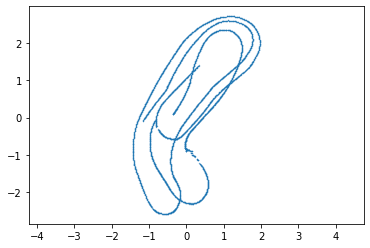

In [26]:
plt.scatter([i[0] for i in p], [j[1] for j in p], s=0.1)
plt.axis('equal')
plt.show()

#### Cam 1

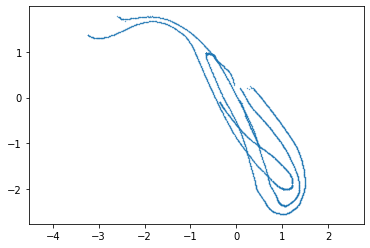

In [29]:
plt.scatter([i[0] for i in p], [j[1] for j in p], s=0.1)
plt.axis('equal')
plt.show()

#### Cam 2

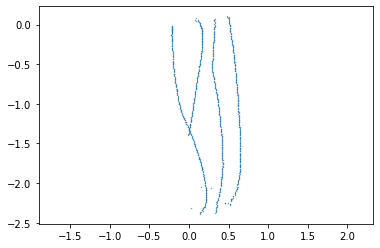

In [33]:
plt.scatter([i[0] for i in p], [j[1] for j in p], s=0.1)
plt.axis('equal')
plt.show()

#### Cam 3

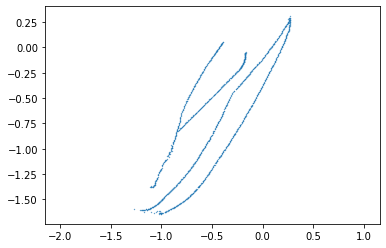

In [36]:
plt.scatter([i[0] for i in p], [j[1] for j in p], s=0.1)
plt.axis('equal')
plt.show()

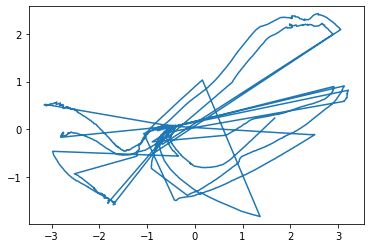

In [27]:
plt.plot([i[0] for i in p], [j[1] for j in p])
plt.axis('equal')
plt.show()

In [24]:
p[0]

array([-3.56030028e-01,  9.03248850e-02, -7.05561913e-06])

In [25]:
r[0]

array([[ 9.9999869e-01,  1.3735377e-04,  1.5927521e-03,  1.8728809e-02],
       [-1.3754267e-04,  9.9999994e-01,  1.1848669e-04, -5.9473229e-04],
       [-1.5927358e-03, -1.1870561e-04,  9.9999869e-01,  1.2493339e-02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)